In [1]:
import os
from tqdm import tqdm
import math
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score
from scipy import stats

from src.utils import parse_filename, normalize, sliding_window

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

from xstream.python.Chains import Chains

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
data_name = "10_150_100_1.0_0.1_1.0_0.1_0.2_abnormal_d.npy"
out_name = "10_150_100_1.0_0.1_1.0_0.1_0.2_abnormal_o.npy"
data_abnormal = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
is_outlier_abnormal = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params_abnormal = parse_filename(data_name)

In [3]:
data_name = "10_150_100_1.0_0.1_0.02_0.6_0.2_local_d.npy"
out_name = "10_150_100_1.0_0.1_0.02_0.6_0.2_local_o.npy"
data_local = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
is_outlier_local = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params_local = parse_filename(data_name)

In [4]:
data_name = "10_150_100_1.0_0.1_0.02_0.1_0.2_global_d.npy"
out_name = "10_150_100_1.0_0.1_0.02_0.1_0.2_global_o.npy"
data_global = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
is_outlier_global = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params_global = parse_filename(data_name)

In [6]:
num_devices = params_global["num_devices"]
dims = params_global["dims"]
subspace_frac = params_global["subspace_frac"]
frac_outlying_devices = params_global["frac_outlying_devices"]
frac_outlying_data = params_global["frac_outlying_data"]
compression_factor = 0.2
num_data = data_global.shape[1]
outlier_type = params_global["outlier_type"]

In [7]:
k = 50
nchains = 50
depth = 10

## Local xStream

In [9]:
models = [Chains(k=k, nchains=nchains, depth=depth) for _ in range(num_devices)]
_ = [model.fit(data_local[i]) for i, model in enumerate(models)]
predictions_xstream_local_dist = np.array([-model.score(data_local[i]) for i, model in enumerate(models)])

Scoring...: 100%|██████████| 50/50 [00:00<00:00, 69.59it/s]


In [10]:
models = [Chains(k=k, nchains=nchains, depth=depth) for _ in range(num_devices)]
_ = [model.fit(data_global[i]) for i, model in enumerate(models)]
predictions_xstream_global_dist = np.array([-model.score(data_global[i]) for i, model in enumerate(models)])

Scoring...: 100%|██████████| 50/50 [00:00<00:00, 68.60it/s]


In [11]:
models = [Chains(k=k, nchains=nchains, depth=depth) for _ in range(num_devices)]
_ = [model.fit(data_abnormal[i]) for i, model in enumerate(models)]
predictions_xstream_abnormal_dist = np.array([-model.score(data_abnormal[i]) for i, model in enumerate(models)])

Scoring...: 100%|██████████| 50/50 [00:00<00:00, 70.03it/s]


## Central xStream

In [12]:
oldshape = data_global.shape
data_global = np.reshape(data_global, newshape=(data_global.shape[0]*data_global.shape[1], data_global.shape[2]))
cf = Chains(k=k, nchains=nchains, depth=depth)
cf.fit(data_global)
predictions_xstream_global_central = -cf.score(data_global)
predictions_xstream_global_central = np.reshape(predictions_xstream_global_central, newshape=(oldshape[0], oldshape[1]))
data_global = np.reshape(data_global, newshape=oldshape)

Scoring...: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]


In [13]:
data_local = np.reshape(data_local, newshape=(data_local.shape[0]*data_local.shape[1], data_local.shape[2]))
cf = Chains(k=k, nchains=nchains, depth=depth)
cf.fit(data_local)
predictions_xstream_local_central = -cf.score(data_local)
predictions_xstream_local_central = np.reshape(predictions_xstream_local_central, newshape=(oldshape[0], oldshape[1]))
data_local = np.reshape(data_local, newshape=oldshape)

Scoring...: 100%|██████████| 50/50 [00:06<00:00,  7.82it/s]


In [14]:
data_abnormal = np.reshape(data_abnormal, newshape=(data_abnormal.shape[0]*data_abnormal.shape[1], data_abnormal.shape[2]))
cf = Chains(k=k, nchains=nchains, depth=depth)
cf.fit(data_abnormal)
predictions_xstream_abnormal_central = -cf.score(data_abnormal)
predictions_xstream_abnormal_central = np.reshape(predictions_xstream_abnormal_central, newshape=(oldshape[0], oldshape[1]))
data_abnormal = np.reshape(data_abnormal, newshape=oldshape)

Scoring...: 100%|██████████| 50/50 [00:06<00:00,  7.65it/s]


In [75]:
def histogram_from_outlier_scores(scores, labels, ax):
    # ugly but working
    io = []
    nio = []
    for i, row in enumerate(scores):
        for j, val in enumerate(row):
            if labels[i][j]:
                nio.append([j, val])
            else:
                io.append([j, val])
    io = pd.DataFrame(io)
    nio = pd.DataFrame(nio)

    # sns.scatterplot(io[0], io[1], label="ok")
    sns.distplot(io[1], hist=False, rug=False, label="is normal", ax=ax)
    sns.distplot(nio[1], hist=False, rug=False, label="is an outlier", ax=ax)
    # sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)

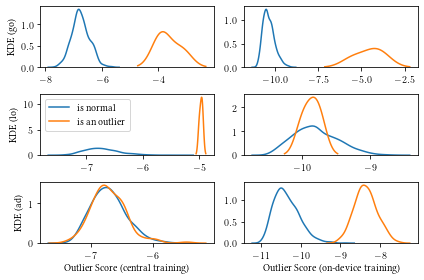

In [76]:
f, axes = plt.subplots(nrows=3, ncols=2, sharex="none", sharey="none")
labels = is_outlier_global.any(axis=-1)
histogram_from_outlier_scores(predictions_xstream_global_dist, labels, ax=axes[0][0])
histogram_from_outlier_scores(predictions_xstream_global_central, labels, ax=axes[0][1])
labels = is_outlier_local.any(axis=-1)
histogram_from_outlier_scores(predictions_xstream_local_dist, labels, ax=axes[1][0])
histogram_from_outlier_scores(predictions_xstream_local_central, labels, ax=axes[1][1])
labels = is_outlier_abnormal.any(axis=-1)
histogram_from_outlier_scores(predictions_xstream_abnormal_dist, labels, ax=axes[2][0])
histogram_from_outlier_scores(predictions_xstream_abnormal_central, labels, ax=axes[2][1])

for ax in axes[0]:
    ax.set(ylabel="KDE (go)")
    
for ax in axes[1]:
    ax.set(ylabel="KDE (lo)")
    
for ax in axes[2]:
    ax.set(ylabel="KDE (ad)")
    
for ax in axes[:, 0]:
    ax.set(xlabel="Outlier Score (central training)")

for ax in axes[:, 1]:
    ax.set(xlabel="Outlier Score (on-device training)")
    
for ax in axes.flat:
    ax.label_outer()
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)
    
for ax in axes.flat:
    ax.get_legend().remove()
    
axes[1][0].legend()

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", "results", "comparison_outliers_xstream.pdf"))